<a href="https://colab.research.google.com/github/Eiko58/Hippocampus_segmentation/blob/main/first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import glob
from google.colab import drive


In [ ]:
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import cv2
import copy
import torchvision.transforms.functional as TF
import random

In [ ]:
drive.mount('/content/drive/')
!pwd

Mounted at /content/drive/
/content


In [ ]:
class img_dataset(Dataset):
  def __init__(self, kind='train'):
    self.kind = kind
    super(Dataset,self).__init__()
    path_kind = 'drive/MyDrive/hippocampus/' + kind
    self.features = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/Total/*.jpg')] # x and y dimension should be divisible by 16 for unet
    self.targets = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/label/*.jpg')]
    assert len(self.features) == len(self.targets), "Something wrong with the dataset"
    
  def __len__(self):
    return len(self.features)
  
    
  def __getitem__(self, index):
    feature, target = self.features[index], self.targets[index]
    feature_tensor = torch.tensor(feature)
    feature_tensor = torch.unsqueeze(feature_tensor/255, 0)
    target_tensor = torch.tensor(target)/255
    target_tensor = torch.round(target_tensor)
    target_tensor = torch.unsqueeze(target_tensor, 0)
    if self.kind == 'train':
      if random.uniform(0,1) > 0.8:
              x_unif = random.uniform(0.5, 1.5)
              feature_tensor = TF.adjust_gamma(feature_tensor, x_unif)
      if random.uniform(0,1) > 0.8:
              x1 = np.random.binomial(4, 0.5) - 2
              y1 = np.random.binomial(4, 0.5) - 2
              x2 = random.uniform(0.9, 1.1)
              x3 = random.uniform(-5, 5)
              feature_tensor = TF.affine(feature_tensor, angle=0, translate = [x1, y1], scale = x2, shear=x3)
              target_tensor = TF.affine(target_tensor, angle=0, translate = [x1, y1], scale = x2, shear=x3) # think it's needed because of shear (?)
      if random.uniform(0,1) > 0.8:
              feature_tensor = TF.gaussian_blur(feature_tensor, 3)
    return feature_tensor, target_tensor



In [ ]:
tr_dataloader = DataLoader(img_dataset(kind='train'), batch_size=8, shuffle=True)
te_dataloader = DataLoader(img_dataset(kind='test'), batch_size=8, shuffle=False)
val_dataloader = DataLoader(img_dataset(kind='validation'), batch_size=8, shuffle=False)

torch.Size([8, 1, 233, 197])
torch.Size([8, 1, 233, 197])
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0157, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0039],
         [0.0156, 0.0171, 0.0181,  ..., 0.0039, 0.0039, 0.0039],
         [0.0155, 0.0188, 0.0209,  ..., 0.0039, 0.0039, 0.0039]]])
torch.Size([8, 1, 233, 197])
torch.Size([8, 1, 233, 197])
torch.Size([8, 1, 233, 197])
torch.Size([8, 1, 233, 197])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


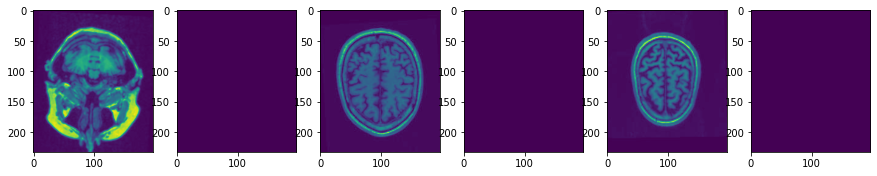

In [ ]:
figure,axis = plt.subplots(1,6,figsize=(15,15))
for batch_features, batch_targets in tr_dataloader:
    print(batch_features.shape)
    print(batch_targets.shape)
    axis[0].imshow(torch.squeeze(batch_features[7], 0).numpy())
    axis[1].imshow(torch.squeeze(batch_targets[2],0).numpy())
    print(batch_features[7])
    break
for batch_features, batch_targets in te_dataloader:
    print(batch_features.shape)
    print(batch_targets.shape)
    axis[2].imshow(torch.squeeze(batch_features[7], 0).numpy())
    axis[3].imshow(torch.squeeze(batch_targets[6],0).numpy())
    break
for batch_features, batch_targets in val_dataloader:
    print(batch_features.shape)
    print(batch_targets.shape)
    axis[4].imshow(torch.squeeze(batch_features[7], 0).numpy())
    axis[5].imshow(torch.squeeze(batch_targets[7], 0).numpy())
    print(batch_targets[7])
    break 

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), #bias=False, because of batchnorm
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of UNet
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #feature*2 because of concatination
      self.ups.append(DoubleConv(feature*2, feature))
    
    # Bottleneck
    self.bottleneck = DoubleConv(features[-1], features[-1]*2)

    # Final Conv
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x) # first has highest resolution
      x = self.pool(x)
    
    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) #ConvTranspose
      skip_connection = skip_connections[i//2]
      if x.shape != skip_connection.shape:
        x = transforms.functional.resize(x, skip_connection.shape[2:]) #ignoring batch size and channel size
      concat_skip = torch.concat((skip_connection, x), dim=1) #dim=1 is channel dimension
      x = self.ups[i+1](concat_skip) # DoubleConv
    
    return self.final_conv(x)


In [ ]:
class diceloss(nn.Module):
  def __init__(self):
    super(diceloss, self).init()
  def forward(self, outcome, label):
    outcome = torch.round(outcome)
    return (2*(outcome*label).sum()) / ((outcome+label).sum()+ 1e-8) 

In [ ]:
model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [ ]:
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = diceloss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
print(criterion1)
print(criterion2)
print(optimizer)

BCEWithLogitsLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
def batch_loss(outputs, labels, batch_size, criterion):
  loss_empty_labels = []
  loss_not_empty_labels = []
  for i in range(batch_size):
    if torch.sum(labels[i]) == 0:
      loss_empty_labels.append(criterion(outputs[i].detach(), labels[i]).item())
    else:
      loss_not_empty_labels.append(criterion(outputs[i].detach(), labels[i]).item())
  return loss_empty_labels, loss_not_empty_labels

In [ ]:
%%capture cap --no-stderr
min_val_loss = float("inf")  # initialize best loss to infinity
for epoch in range(2):       # loop over the dataset multiple times (= epochs)

    empty_bce = []  # variable to accumulate the loss across mini-batches
    nempty_bce = []
    total_bce = 0.0
    empty_dice = []
    nempty_dice = []
    total_dice = 0.0
    model.train()     # set model to training mode for gradient accumulation (often forgotten and leads to bugs!)
    for i, data in enumerate(tr_dataloader):  # loop through the mini-batches
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)          # perform inference
        loss = criterion1(outputs, labels) # compute loss
        
        bcee, bcen = batch_loss(outputs, labels, outputs.shape[0], criterion1)
        empty_bce.extend(bcee)
        nempty_bce.extend(bcen)
        total_bce += loss.item()

        dicee, dicen = batch_loss(outputs, labels, outputs.shape[0], criterion2)
        empty_dice.extend(dicee)
        nempty_dice.extend(dicen)
        total_dice += criterion2(outputs, labels).item()

        loss.backward()                    # compute gradients
        optimizer.step()                   # optimizer updates weights using gradients

        
        
        if i % 500 == 499:    # print every 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] empty_bce: {np.mean(np.array(empty_bce)):.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] nempty_bce: {np.mean(np.array(nempty_bce)):.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] total_bce: {total_bce/500:.3f}')
            empty_bce = []
            nempty_bce = []
            total_bce = 0.0
                        
            print(f'[{epoch + 1}, {i + 1:5d}] empty_dice: {np.mean(np.array(empty_dice)):.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] nempty_dice: {np.mean(np.array(nempty_dice)):.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] total_dice: {total_dice/500:.3f}')
            empty_dice = []
            nempty_dice = []
            total_dice = 0.0
            

    
    model.eval()  # set to evaluation mode 
    val_loss_empty_bce = []
    val_loss_nempty_bce = []
    val_loss_empty_dice = []
    val_loss_nempty_dice = []
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            val_loss_bcee, val_loss_bcen = batch_loss(outputs, labels, outputs.shape[0], criterion1)
            val_loss_dicee, val_loss_dicen = batch_loss(outputs, labels, outputs.shape[0], criterion2)
            # print statistics
            val_loss_empty_bce.extend(val_loss_bcee)
            val_loss_nempty_bce.extend(val_loss_bcen)
            val_loss_empty_bce.extend(val_loss_dicee)
            val_loss_nempty_bce.extend(val_loss_dicen)

    num_validation_batches = len(val_dataloader)
    print(f'Average val loss empty_bce: {np.mean(np.array(val_loss_empty_bce)):.3f}')
    print(f'Average val loss nempty_bce: {np.mean(np.array(val_loss_nempty_bce)):.3f}')
    print(f'Average val loss empty_dice: {np.mean(np.array(val_loss_empty_dice)):.3f}')
    print(f'Average val loss nempty_dice: {np.mean(np.array(val_loss_nempty_dice)):.3f}')
    if np.mean(np.array(val_loss_empty_bce))+np.mean(np.array(val_loss_nempty_bce)) +np.mean(np.array(val_loss_nempty_dice)) + np.mean(np.array(val_loss_empty_dice))  < min_val_loss:
        min_val_loss = np.mean(np.array(val_loss_empty_bce))+np.mean(np.array(val_loss_nempty_bce)) +np.mean(np.array(val_loss_nempty_dice)) + np.mean(np.array(val_loss_empty_dice))
        print(f'The new best model is at epoch {epoch}')
        torch.save(model.state_dict(), 'drive/MyDrive/models/unet.pth')  # save the network
    print(f'Epoch: {epoch} over')


 

[1,   500] running_loss_when_empty: 0.000
[1,   500] running_loss_not_empty: 0.008
[1,   500] running_total_loss: 0.001
[1,   500] no_loss: 0.693
[1,  1000] running_loss_when_empty: 0.000
[1,  1000] running_loss_not_empty: 0.006
[1,  1000] running_total_loss: 0.001
[1,  1000] no_loss: 0.693
[1,  1500] running_loss_when_empty: 0.000
[1,  1500] running_loss_not_empty: 0.006
[1,  1500] running_total_loss: 0.001
[1,  1500] no_loss: 0.693
[1,  2000] running_loss_when_empty: 0.000
[1,  2000] running_loss_not_empty: 0.005
[1,  2000] running_total_loss: 0.001
[1,  2000] no_loss: 0.693
Average val loss when empty: 0.000
Average val loss when not empty: 0.005
The new best model is at epoch 0
Epoch: 0 over
[2,   500] running_loss_when_empty: 0.000
[2,   500] running_loss_not_empty: 0.005
[2,   500] running_total_loss: 0.001
[2,   500] no_loss: 0.693
[2,  1000] running_loss_when_empty: 0.000
[2,  1000] running_loss_not_empty: 0.004
[2,  1000] running_total_loss: 0.001
[2,  1000] no_loss: 0.693
[2,

In [ ]:

with open('drive/MyDrive/logs/errors1.txt', 'w') as f:
  f.write(f'{model}')
  f.write('\n')
  f.write(f'{criterion}')
  f.write('\n')
  f.write(f'{optimizer}')
  f.write(cap.stdout)

In [ ]:
def most_frequent(List):
    return max(set(List), key = List.count)

In [ ]:
img = batch_targets[7]
most_frequent(list(torch.flatten(img).numpy()))
x = [most_frequent(list(torch.flatten(img).numpy()))] * len(torch.flatten(img))
len(img[img==x[1]]), len(torch.flatten(img))

(45901, 45901)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
print(criterion(torch.tensor(np.array(x)).reshape(img.shape), img).item())
print(criterion(img, img).item())
rand_img = torch.randn(img.shape)
criterion(rand_img, img).item()

0.6970148086547852
0.6970148086547852


0.8064162731170654

In [ ]:
print(criterion(batch_targets, batch_targets).item())
print(criterion(torch.randn(batch_targets.shape), batch_targets).item())

0.6970149874687195
0.8056691288948059
